## First short insight into dataset
**Review paper of CheXpert dataset**: Jeremy, Irvin, et al. "CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison" The Thirty-Third AAAI Conference on Artificial Intelligence (AAAI-19). https://arxiv.org/abs/1901.07031
Overviuew:
* Over 200k thorax scans of more than 65k patients
* Mostly frontal views of thorax scans for the detection of 14 diseases, for some patients are also lateral scans presented
* Uncertainty labels possible, labels are yes/no/uncertain (1/0/-1)
* Unbalanced dataset, for some diseases only a small percentage of labels are positiv



In [1]:
import matplotlib.pyplot as plt

def plot_image(img, normalize: bool = True) -> None:
    if normalize:
        img = img - img.min()
        img = img / img.max()
    if len(img.shape) == 2:
        img = image.unsqueeze(0)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.show()

2022-04-22 13:42:36 ae3bc10f518f key2med.data.label_reader[3835576] INFO Found labels in /data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/train.csv: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
Reading label csv file /data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/train.csv: 0it [00:00, ?it/s]
2022-04-22 13:42:36 ae3bc10f518f key2med.data.label_reader[3835576] INFO Found labels in /data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/valid.csv: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
Reading label csv file /data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/valid.csv: 234it [00:00, 74670.3

1,000 samples for training
234 samples for validation


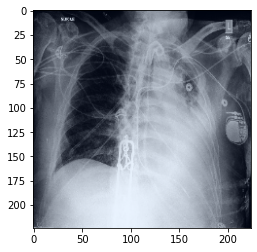

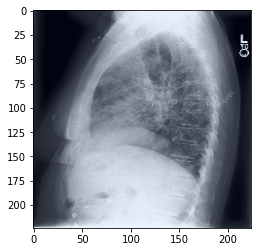

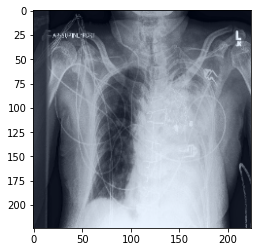

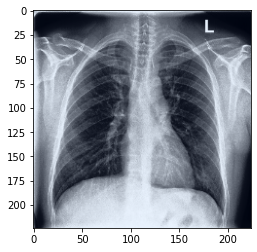

In [2]:
# Please use the given dataloader only for a first visualization and not during your own implementation of a dataloader
from key2med.data.loader import ColorCheXpertDataLoader

dataloader = ColorCheXpertDataLoader(data_path="/data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/",
                                    batch_size=4,
                                    img_resize=224,
                                    channels=3,
                                    do_random_transform=False,
                                    use_cache=False,
                                    in_memory=False,
                                    max_size=1000,
                                    print_stats=False)
for batch in dataloader.train:
    images, labels = batch
    for image, label in zip(images, labels):
        plot_image(image)
    break

# Data Loader

**Learning outcomes**: How can you load the scans of different patients for training? What challenges can exist with medical data? What kind of preprocessing is needed to handle this challenges? 

**Work Pipeline**:
* Read images 
* Read labels
* Combine image and label reader in one CheXpert dataset
* Implement dataloader for CheXpert dataset


## Import packages

In [3]:
import csv
import os
import random
import logging
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

from key2med.utils.logging import tqdm
from key2med.utils.transforms import (BaseTransform, ColorTransform,
                                      RandomAffineTransform, Transform)

Path = str
ImagePath = str
Label = int

logger = logging.getLogger(__name__)

## Implement image reader
**Goal**: read images of CheXpert dataset <br>
* Load PNG/JPG images from given path
* Apply transformation, which is passed as input

In [4]:
class ImageReader:
    """
    Basic class for loading images, transforming and caching
    """

    def __init__(self,
                 base_path: Path,
                 image_paths: List[ImagePath],
                 in_memory: bool = False,
                 transform: Transform = None):
        """
        :base_path: Basic path
        :param image_paths: paths to images, that should be loaded
        :param in_memory: Boolean, if you want to load the images in memory befor you start training
        :param transform: Tranformation of the images e.g. Resizing
        """
        
        self.base_path = base_path
        self.in_memory = in_memory
        self.transform = transform or self.default_transform

        self.images = None

        if self.in_memory:
            logger.info(f'Reading all data into memory.')
            self.images: Dict[ImagePath: Any] = {path: self.load_image(path) for path in tqdm(image_paths, desc='Loading all data into memory')}

    @property
    def default_transform(self) -> Transform:
        return ResizeTransform(image_dim=224)

    @property
    def image_dim(self):
        return self.transform.image_dim

    
    def load_image(self, path) -> torch.tensor:
        if self.images is not None:
            image = self.images[path]
            return torch.tensor(image)
        full_image_path = os.path.join(self.base_path, path)
        image = Image.open(os.path.join(self.base_path, full_image_path))
        image = np.array(image)
        if len(image.shape) == 3:
            image = image[:, :, 0]
        if self.transform is not None:
            image = self.transform(image)
        return torch.tensor(image)


### Transformation
* Implement different transformations for images e.g. resizing, cropping, normalization, flipping, see the ResizeTransform as a basic example

In [5]:
class Transform:
    transform = None

    def __call__(self, x):
        return self.transform(x)
    
class ResizeTransform(Transform):

    def __init__(self, image_dim: int):
        self.image_dim = image_dim
        self.transform = self._transform

    def _transform(self, x):
        x = np.array(x).astype(np.float32)
        x = cv2.resize(x, dsize=(self.image_dim, self.image_dim), interpolation=cv2.INTER_LINEAR)
        return x

### Test PNG reader

2022-04-22 13:42:45 ae3bc10f518f __main__[3835576] INFO Reading all data into memory.
Loading all data into memory: 100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 129.95it/s]

torch.Size([224, 224])



/tmp/ipykernel_3835576/2114435931.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)


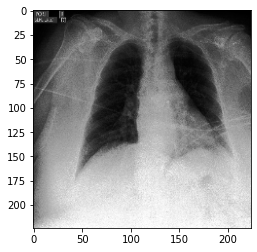

In [6]:
# Image reader test

base_path = "/data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small"

all_images = [
'train/patient00001/study1/view1_frontal.jpg',
'train/patient00002/study2/view1_frontal.jpg',
'train/patient00002/study1/view1_frontal.jpg',
'train/patient00002/study1/view2_lateral.jpg',
'train/patient00003/study1/view1_frontal.jpg',
'train/patient00004/study1/view1_frontal.jpg',
'train/patient00004/study1/view2_lateral.jpg',
'train/patient00005/study1/view1_frontal.jpg',
'train/patient00005/study1/view2_lateral.jpg',
'train/patient00005/study2/view1_frontal.jpg',
'train/patient00005/study2/view2_frontal.jpg',
'train/patient00006/study1/view1_frontal.jpg',
'train/patient00007/study1/view1_frontal.jpg',
'train/patient00007/study2/view1_frontal.jpg',
'train/patient00008/study1/view1_frontal.jpg',
'train/patient00008/study2/view1_frontal.jpg',
'train/patient00009/study1/view1_frontal.jpg',
'train/patient00009/study1/view2_lateral.jpg',
'train/patient00010/study1/view1_frontal.jpg',
]
first_batch = all_images[:5]

# Implement transformations e.g. resize, rotation, flipping etc.
transform = ResizeTransform(image_dim=224)

image_reader = ImageReader(base_path=base_path, image_paths=first_batch,in_memory=True, transform=transform)

for path in all_images:
    image = image_reader.load_image(path)
    print(image.shape)
    plot_image(image)
    break

## Implement label reader
**Goal**: read labels of CheXpert dataset <br>
Implement CheXpert label reader, that includes: <br>
* Reading of the labels from the csv file
* Defining label filter, if only some labels are relevant for the model
* Filtering of data regarding their view, direction, sex, age or label
* Handeling the uncertainty in labels

In [7]:
class ChexpertLabelReader:
    sex_values = {
        'Male': 0,
        'Female': 1,
        'Unknown': 2
    }
    view_values = {
        'Frontal': 0,
        'Lateral': 1
    }
    direction_values = {
        'AP': 0,
        'PA': 1,
        'LL': 2,
        'RL': 3,
        '': 4
    }

    def __init__(self,
                 label_file,
                 label_filter: List[int] = None,
                 uncertain_to_one: Union[str, List[str]] = None,
                 uncertain_to_zero: Union[str, List[str]] = None,
                 uncertain_upper_bound: float = 0.5,
                 uncertain_lower_bound: float = 0.5,
                 valid_views: List[str] = None,
                 valid_sexs: List[str] = None,
                 valid_directions: List[str] = None,
                 min_age: int = None,
                 max_age: int = None,
                 max_size: int = None):
        """
        :param label_file: csv file with labels
        :param label filter: used to only consider one disease not all 14
        :param uncertain_to_one: List of which diseases should map uncertainty to 1
        :param uncertain_to_zero: List of which diseases should map uncertainty to 0
        :param uncertain_upper_bound: Map uncertainty between upper- and lower_bound
        :param uncertain_lower_bound: Map uncertainty between upper- and lower_bound
        :param valid_views: List of Strings, views that are considered e.g. "Frontal".
        :param valid_sexs: One or multiple of ['Unknown', 'Male', 'Female']
        :param valid directions: One or multiple of ['', 'AP', 'PA', 'LL', 'RL']
        :param min_age: Integer, Minimum age of person in xray.
        :param max_age: Integer, Maximimum age of person in xray
        :param max_size: Limit for number of images in training and validation each. For debugging.
        """
        self.label_file = label_file
        self.max_size = max_size

        self.valid_views: List[str] = valid_views or list(self.view_values.keys())
        self.valid_directions: List[str] = valid_directions or list(self.direction_values.keys())
        self.valid_sexs: List[str] = valid_sexs or list(self.sex_values.keys())
        self.min_age = min_age or 0
        self.max_age = max_age or 100

        self.uncertain_to_one, self.uncertain_to_zero = self.init_uncertain_mapping(uncertain_to_one, uncertain_to_zero)
        self.uncertain_upper_bound, self.uncertain_lower_bound = uncertain_upper_bound, uncertain_lower_bound

        self.data, self.index_to_label = self.read_label_csv(label_file, label_filter)
        self.label_to_index = {label: index for index, label in enumerate(self.index_to_label)}

        self.data = self.filter_data(self.data)
        self.image_paths = list(self.data.keys())

    def __getitem__(self, path):
        data = self.data[path]
        return self.prepare_data(data)

    @property
    def label_dim(self) -> Optional[int]:
        """
        Number of labels in the dataset.
        Default CheXpert 14, competition mode 5.
        :return: int Number of labels
        """
        return len(self.index_to_label)

    def filter_data(self, data: Dict[ImagePath, Dict]):
        filtered_data = {}

        for image_path, image_data in data.items():
            if image_data['view'] not in self.valid_views:
                continue
            if image_data['direction'] not in self.valid_directions:
                continue
            if image_data['sex'] not in self.valid_sexs:
                continue
            if not self.min_age <= image_data['age'] <= self.max_age:
                continue
            filtered_data[image_path] = image_data
        return filtered_data

    def prepare_data(self, data: Dict) -> torch.Tensor:
        # sex = self.sex_values[data['sex']]
        # view = self.view_values[data['view']]
        # direction = self.direction_values[data['direction']
        labels = self.convert_labels_live(data['labels'])
        return labels

    def convert_labels_live(self, labels: torch.tensor) -> torch.tensor:
        labels = torch.tensor(
            [self.convert_uncertain_labels(label, self.index_to_label[i]) for i, label in enumerate(labels)])
        return labels

    def convert_uncertain_labels(self, label: torch.tensor, label_name: str):
        if label != -1.0:
            return label

        if label_name in self.uncertain_to_zero:
            return 0.0
        if label_name in self.uncertain_to_one:
            return 1.0
        if self.uncertain_upper_bound != self.uncertain_lower_bound:
            return random.uniform(self.uncertain_lower_bound, self.uncertain_upper_bound)
        return self.uncertain_lower_bound

    @staticmethod
    def init_uncertain_mapping(uncertain_to_one: Optional[Union[str, List[str]]],
                               uncertain_to_zero: Optional[Union[str, List[str]]]):
        if uncertain_to_one is None:
            uncertain_to_one = []
        elif uncertain_to_one == 'best':
            uncertain_to_one = ['Edema', 'Atelectasis']

        if uncertain_to_zero is None:
            uncertain_to_zero = []
        elif uncertain_to_zero == 'best':
            uncertain_to_zero = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

        return uncertain_to_one, uncertain_to_zero

    def init_label_filter(self, label_filter: Union[List[int], str], label_names: List[str]) -> Optional[List[int]]:
        if label_filter is None or label_filter == 'full':
            return None
        if label_filter == 'competition':
            return [2, 5, 6, 8, 10]
        if isinstance(label_filter, list) and isinstance(label_filter[0], int):
            return label_filter
        if isinstance(label_filter, list) and isinstance(label_filter[0], str):
            return [index for index, label_name in enumerate(label_names) if label_name in label_filter]
        raise NotImplementedError

    def read_label_csv(self, file, label_filter) -> Tuple[Dict, List[str]]:
        """
        Read CheXpert label csv.
        :param file: Path to .csv
        :param label_filter: xx
        :return: Tuple[Dict, List[str]] Label data dictionary and list of label names.
        """
        data: Dict[ImagePath, Dict] = {}
        with open(file, 'r') as f:
            reader = csv.reader(f)
            label_names = next(reader)[5:]
            label_filter: List[int] = self.init_label_filter(label_filter, label_names)
            logger.info(f'Found labels in {file}: {label_names}')
            for index, row in tqdm(enumerate(reader), desc=f'Reading label csv file {file}'):
                image_path = row[0]
                data[image_path] = self.read_row(row, label_names, label_filter)
                if self.max_size is not None and index > self.max_size:
                    break
        if label_filter is not None:
            label_names = [label_names[i] for i in label_filter]
        return data, label_names

    def read_row(self, row: List, label_names: List[str], label_filter: List[int]) -> Dict[str, Any]:
        """
        Read a single row in the label csv. Convert the labels.
        :param row: List[str]
        :param label_filter: xx
        :return: Dict
        """
        return {
            'sex': row[1],
            'age': int(row[2]),
            'view': row[3],
            'direction': row[4],
            'labels': self.convert_labels(row[5:], label_names, label_filter)
        }


    def convert_labels(self, labels: List[str], label_names: List[str], label_filter: List[int]) -> torch.Tensor:
        """
        Label conversion while reading the label file.
        Only done once before training. No random transformations here.

        Possible labels:
        '1.0': positive
        '0.0': negative
        '-1.0': uncertain
        '': no mention

        :param labels: Labels from row of .csv file. As strings.
        :param label_filter: xx
        :return: torch.Tensor or list of floats. Initially converted labels.
        """
        convert = {
            '1.0': 1.0,
            '0.0': 0.0,
            '': 0.0,
            '-1.0': -1.0
        }
        labels = torch.FloatTensor([convert[x] for x in labels])
        if label_filter is not None:
            labels = labels[label_filter]
        return labels

### Test Label reader

In [8]:
path = "/data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/valid.csv"
label_reader = ChexpertLabelReader(path)
print(label_reader.data)

2022-04-22 13:42:49 ae3bc10f518f __main__[3835576] INFO Found labels in /data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/valid.csv: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
Reading label csv file /data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/valid.csv: 234it [00:00, 39796.74it/s]

{'CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg': {'sex': 'Male', 'age': 73, 'view': 'Frontal', 'direction': 'AP', 'labels': tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, 'CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg': {'sex': 'Male', 'age': 70, 'view': 'Frontal', 'direction': 'PA', 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}, 'CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg': {'sex': 'Male', 'age': 70, 'view': 'Lateral', 'direction': '', 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}, 'CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg': {'sex': 'Male', 'age': 85, 'view': 'Frontal', 'direction': 'AP', 'labels': tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])}, 'CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg': {'sex': 'Female', 'age': 42, 'view': 'Frontal', 'direction': 'AP', 'labels': tensor([1., 0., 0., 0

# Dataset

**Goal**: Combining image and label reader in CheXpert dataset class <br>
Implement cheXpert dataset, that includes: <br>
* Reading of the labels with the label reader
* Reading of images with the image reader
* Map image to corresponding label of label reader
* Plotting of the statistic records of the dataset
* Handeling unbalanced dataset e.g. upsampling of underrepresented diseases
* Set default transformations

In [9]:
from typing import List, Tuple, Dict, Optional, Union, Any
import os
import random
from pathlib import Path

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset

from key2med.utils.transforms import BaseTransform, Transform, RandomAffineTransform
from key2med.utils.plotting import text_histogram
from key2med.utils.helper import hash_dict

ImagePath = str
Label = str

In [10]:
class CheXpertDataset(Dataset):

    def __init__(self,
                 data_path: str,
                 split: str,
                 random_transform: Transform = None,
                 upsample_label: str = None,
                 downsample_label: str = None,
                 max_size: int = None,
                 print_stats: bool = True,
                 # label_reader kwargs
                 label_filter: List[int] = None,
                 uncertain_to_one: Union[str, List[str]] = None,
                 uncertain_to_zero: Union[str, List[str]] = None,
                 uncertain_upper_bound: float = 0.5,
                 uncertain_lower_bound: float = 0.5,
                 valid_views: List[str] = None,
                 valid_sexs: List[str] = None,
                 valid_directions: List[str] = None,
                 min_age: int = None,
                 max_age: int = None,
                 # image_reader kwargs
                 in_memory: bool = True,
                 transform: Transform = None,
                 ):
        """
        :param do_random_transform: Boolean, do a random transform when loading a training image.
        :param upsample_label: String, target that will be upsampled.
        :param downsample_label: String, target that will be downsampled.
        """
        self.split = split
        parent_directory, chexpert_directory = self.split_data_path(data_path)
        label_file, sub_split = self.get_label_file(split)
        self.label_reader = self.init_label_reader(label_file=os.path.join(parent_directory, chexpert_directory, label_file),
                                                   label_filter=label_filter,
                                                   uncertain_to_one=uncertain_to_one,
                                                   uncertain_to_zero=uncertain_to_zero,
                                                   uncertain_upper_bound=uncertain_upper_bound,
                                                   uncertain_lower_bound=uncertain_lower_bound,
                                                   valid_views=valid_views,
                                                   valid_sexs=valid_sexs,
                                                   valid_directions=valid_directions,
                                                   min_age=min_age,
                                                   max_age=max_age,
                                                   max_size=max_size)
        self.image_paths = self.get_image_paths(self.label_reader)
        if sub_split is not None:
            self.image_paths = self.split_paths(self.image_paths, sub_split=sub_split, train_size=0.9)
        if max_size is not None:
            self.image_paths = self.image_paths[:max_size]

        transform = transform or self.default_transform
        self.random_transform = random_transform or self.default_random_transform

        
        self.image_reader = self.init_image_reader(base_path=parent_directory,
                                                   image_paths=self.image_paths,
                                                   transform=transform,
                                                   in_memory=in_memory)

        if upsample_label is not None:
            self.image_paths = self.upsample_data(self.image_paths, upsample_label)
        if downsample_label is not None:
            self.image_paths = self.downsample_data(self.image_paths, downsample_label)

        self.image_path_mapping: List[ImagePath] = self.create_image_path_mapping()
        if print_stats:
            self.print_label_stats()
            
    def __getitem__(self, index) -> Tuple[List[torch.tensor], List[Any]]:
        if index >= len(self):
            raise IndexError
        image_path = self.image_path_mapping[index]
        image = self.image_reader.load_image(image_path)
        if self.random_transform is not None:
            image = self.random_transform(image)
        image_data = self.load_image_data(image_path)
        return image, image_data

    def split_data_path(self, data_path: str) -> Tuple[str, str]:
        split = Path(data_path).parts
        return str(Path(*split[:-1])), split[-1]

    def init_label_reader(self, **label_reader_kwargs):
        return ChexpertLabelReader(**label_reader_kwargs)

    def init_image_reader(self, **image_reader_kwargs):
        return ImageReader(**image_reader_kwargs)

    def get_image_paths(self, label_reader):
        return label_reader.image_paths

    def __len__(self):
        return len(self.image_paths)

    def load_image_data(self, image_path):
        return self.load_image_labels(image_path)

    def load_image_labels(self, image_path):
        return self.label_reader[image_path]

    def load_image_metadata(self, image_path):
        return self.label_reader.data[image_path]

    def upsample_data(self, image_paths, upsample_label: str):
        positive_items = self.get_positive_items(image_paths, upsample_label)
        n_upsample = len(image_paths) - 2 * len(positive_items)
        new_data = random.choices(positive_items, k=n_upsample)
        image_paths += new_data
        return image_paths

    def get_positive_items(self, image_paths, label):
        label_index = self.label_reader.label_to_index[label]
        positive_values = []
        for item in image_paths:
            if self.label_reader.data[item]['labels'][label_index] == 1.:
                positive_values.append(item)
        return positive_values

    def get_negative_items(self, image_paths, label):
        label_index = self.label_reader.label_to_index[label]
        positive_values = []
        for item in image_paths:
            if self.label_reader.data[item]['labels'][label_index] == 0.:
                positive_values.append(item)
        return positive_values

    def downsample_data(self, image_paths, downsample_label: str):
        positive_items = self.get_positive_items(image_paths, downsample_label)
        negative_items = self.get_negative_items(image_paths, downsample_label)
        negative_items = random.choices(negative_items, k=len(positive_items))
        image_paths = positive_items + negative_items
        return image_paths

    @property
    def imratio(self) -> float:
        all_labels = self.all_labels_flat
        return (all_labels.sum() / len(all_labels)).item()

    @property
    def imratios(self) -> List[float]:
        stats = self.label_stats
        return [stat['positive_count'] for stat in stats.values()]

    @property
    def all_labels_flat(self) -> torch.tensor:
        return self.all_labels.view(-1)

    @property
    def index_to_label(self):
        return self.label_reader.index_to_label

    @property
    def all_labels(self) -> torch.tensor:
        labels: List[torch.tensor] = [self.label_reader[path] for path in self.image_path_mapping]
        labels: torch.tensor = torch.stack(labels)
        return labels

    @property
    def label_stats(self) -> Dict[Label, Dict]:
        label_stats: Dict[Label, Dict] = {}
        all_datas = self.all_labels
        n = len(all_datas)
        positive_counts = (all_datas == 1.).sum(axis=0)
        negative_counts = (all_datas == 0.).sum(axis=0)
        uncertain_counts = ((all_datas != .0) & (all_datas != 1.)).sum(axis=0)
        for label_name, pos, neg, unc in zip(self.index_to_label, positive_counts, negative_counts, uncertain_counts):
            label_stats[label_name] = {
                'positive_count': pos,
                'positive_ratio': pos / n,
                'negative_count': neg,
                'negative_ratio': neg / n,
                'uncertain_count': unc,
                'uncertain_ratio': unc / n,
            }
        return label_stats

    def create_image_path_mapping(self) -> List[ImagePath]:
        return self.image_paths

    def print_label_stats(self):
        """
        Plot stats on the distribution of labels and image metadata to the
        command line.
        :return: None
        """
        label_stats = self.label_stats
        imratio_message = f'\n\t{"=" * 10} SPLIT {self.split} {"=" * 10}:\n' \
                          f'\tTotal images in split:  {len(self.image_paths):,}\n' \
                          f'\tTotal items in split:  {len(self.image_path_mapping):,}\n' \
                          f'\tTotal imratio in split: {self.imratio:.1%}.\n'

        max_label_length: int = max([len(label) for label in label_stats.keys()])
        for label, stats in label_stats.items():
            imratio_message += f'\t{label: <{max_label_length + 1}}: ' \
                               f'{stats["positive_count"]:>7,} positive, ' \
                               f'{stats["negative_count"]:>7,} negative, ' \
                               f'{stats["uncertain_count"]:>7,} uncertain, ' \
                               f'{stats["positive_ratio"]:>7.1%} imratio.\n'
        logger.info(imratio_message)

    @property
    def all_metadata(self) -> List[Dict]:
        return [self.load_image_metadata(path) for path in self.image_path_mapping]

    @property
    def default_transform(self) -> Transform:
        return BaseTransform()

    @property
    def default_random_transform(self) -> Transform:
        return RandomAffineTransform()

    @property
    def image_dim(self):
        return self.image_reader.image_dim

    @property
    def label_dim(self):
        return self.label_reader.label_dim

    @staticmethod
    def split_paths(paths, sub_split, train_size: float = 0.9) -> List[ImagePath]:
        train_paths, test_paths = train_test_split(paths, train_size=train_size, random_state=42)
        if sub_split == 'train':
            return train_paths
        if sub_split == 'test':
            return test_paths

    def get_label_file(self, split):
        if split == 'train':
            return 'train.csv', 'train'
        if split == 'valid':
            return 'train.csv', 'test'
        if split == 'test':
            return 'valid.csv', None

# Data Loader

**Goal**: Data loader that loads the CheXpert dataset <br>
Implement dataloader that includes: <br>
* Initialisation of already implemented datset
* Splitting of dataset


In [11]:
class CheXpertDataLoader:
    """
    Dataloader for CheXpert dataset.
    When called with a valid path to the chexpert dataset, initializes
    the training and validation split given by chexpert.
    Most arguments given to init are passed on to chexpert datasets.
    """

    def __init__(self,
                 data_path,
                 batch_size: int = 16,
                 img_dim: int = 224,
                 channels: int = 3,
                 # dataset kwargs
                 transform: Transform = None,
                 do_random_transform: bool = True,
                 upsample_label: str = None,
                 downsample_label: str = None,
                 max_size: int = None,
                 print_stats: bool = True,
                 # label_reader kwargs
                 label_filter: List[int] = None,
                 uncertain_to_one: Union[str, List[str]] = None,
                 uncertain_to_zero: Union[str, List[str]] = None,
                 uncertain_upper_bound: float = 0.5,
                 uncertain_lower_bound: float = 0.5,
                 #one_labels: List[str] = None,
                 valid_views: List[str] = None,
                 valid_sexs: List[str] = None,
                 valid_directions: List[str] = None,
                 min_age: int = None,
                 max_age: int = None,
                 # image_reader kwargs
                 in_memory: bool = True,
                 # dataloader kwargs
                 n_workers: int = 1):
        """
        :param data_path: Path to chexpert dataset.
        :param batch_size: Batch size for both training and validation.
        _param img_dim: Dimension of image.
        :param channels: Number of image channels. CheXpert are B/W-images by default, one channel. Most pretrained vision models
                         expect 3 channels for color. By default, this class implements a transform that copies the grayscale values
                         from one channel to 3 channels.
        :param transform: Transform class object to transform the data before training. By default resizes the image to img_resize.
        :param do_random_transform: Boolean, do a random transform when loading a training image.
        :param upsample_label: String, target that will be upsampled.
        :param downsample_label: String, target that will be downsampled.
        :param max_size: Limit for number of images in training and validation each. For debugging.
        :param print_stats: Boolean, plot statistic of targets.
        :param label_filter: Set to 'competition' to only train and evaluate on the competition classes:
                     'Edema', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Pleural Effusion'
        :param uncertain_to_one: Labels for which uncertain values should be mapped onto 1.0. List of string with the label name.
        :param uncertain_to_zero: Labels for which uncertain values should be mapped onto 0.0. List of string with the label name.
        :param uncertainty_upper_bound: Uncertain values (if not in uncertain_to_one or uncertain_to_zero) are mapped onto an interval
                                        between uncertainty_upper_bound and uncertainty_lower_bound.
                                        To map onto exactly one value set both values the same.
        :param uncertainty_lower_bound: Uncertain values (if not in uncertain_to_one or uncertain_to_zero) are mapped onto an interval
                                        between uncertainty_upper_bound and uncertainty_lower_bound.
                                        To map onto exactly one value set both values the same.
        :param valid_views: List of Strings, views that are considered e.g. "Frontal".
        :param valid_sexs: One or multiple of ['Unknown', 'Male', 'Female']
        :param valid directions: One or multiple of ['', 'AP', 'PA', 'LL', 'RL']
        :param min_age: Integer, Minimum age of person in xray.
        :param max_age: Integer, Maximimum age of person in xray.
        :param in_memory: Boolean, Load the entire dataset into memory before starting the training.
        :param n_worker: Number of processes for the torch dataloader
        """

        self.batch_size = batch_size
        self.n_workers = n_workers
        
        self.img_dim = img_dim
        
        self.random_transform = RandomAffineTransform(self.img_dim) if do_random_transform else None
        
        base_kwargs = {
            "data_path": data_path,
            "transform": transform or self.default_transform,
            "max_size": max_size,
            "print_stats": print_stats,
            "label_filter": label_filter,
            "uncertain_to_one": uncertain_to_one,
            "uncertain_to_zero": uncertain_to_zero,
            "uncertain_upper_bound": uncertain_upper_bound,
            "uncertain_lower_bound": uncertain_lower_bound,
            "valid_views": valid_views,
            "valid_sexs": valid_sexs,
            "valid_directions": valid_directions,
            "min_age": min_age,
            "max_age": max_age,
            "in_memory": in_memory,
        }

        train_dataset = CheXpertDataset(**base_kwargs,
                                          split='train',
                                          random_transform=self.random_transform,
                                          upsample_label=upsample_label,
                                          downsample_label=downsample_label)

        valid_dataset = CheXpertDataset(**base_kwargs,
                                          split='valid',
                                          random_transform=None,
                                          upsample_label=None,
                                          downsample_label=None)

        test_dataset = CheXpertDataset(**base_kwargs,
                                         split='test',
                                         random_transform=None,
                                         upsample_label=None,
                                         downsample_label=None)

        self.index_to_label = train_dataset.index_to_label

        self.train_set_size = 0
        self.train = None
        self.valid_set_size = 0
        self.validate = None
        self.test_set_size = 0
        self.test = None
        self.init_split_from_split(train_dataset, valid_dataset, test_dataset)

    def init_dataset(self, *args, **kwargs):
        return 
    
    def init_split_from_split(self, train_dataset, valid_dataset, test_dataset):
        if train_dataset is not None:
            self.train_set_size = len(train_dataset)
            self.train = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size,
                                                              shuffle=True, num_workers=self.n_workers)
            print(f'{self.train_set_size:,} samples for training')

        if valid_dataset is not None:

            self.valid_set_size = len(valid_dataset)
            self.validate = torch.utils.data.DataLoader(valid_dataset, batch_size=self.batch_size,
                                                              shuffle=True, num_workers=self.n_workers)
            print(f'{self.valid_set_size:,} samples for validation')

        if test_dataset is not None:
            self.test_set_size = len(test_dataset)
            self.test = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size,
                                                             shuffle=True, num_workers=self.n_workers)
            print(f'{self.test_set_size:,} samples for testing')
    
    @property
    def n_train_batches(self):
        if self.train is None:
            return 0
        return len(self.train)

    @property
    def n_validate_batches(self):
        if self.validate is None:
            return 0
        return len(self.validate)

    @property
    def n_test_batches(self):
        if self.test is None:
            return 0
        return len(self.test)
    
    @property
    def default_transform(self):
        return ColorTransform(self.img_dim)

    @property
    def label_dim(self):
        if self.train is not None:
            return self.train.dataset.label_dim
        if self.validate is not None:
            return self.validate.dataset.label_dim
        if self.test is not None:
            return self.test.dataset.label_dim

In [12]:
path = "/data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/"
ColorCheXpertDataLoader = CheXpertDataLoader(path, max_size=100, label_filter=["Pneumothorax"])

2022-04-22 13:43:01 ae3bc10f518f __main__[3835576] INFO Found labels in /data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/train.csv: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
Reading label csv file /data/MEDICAL/datasets/CheXpert_small/CheXpert-v1.0-small/train.csv: 0it [00:00, ?it/s]
2022-04-22 13:43:01 ae3bc10f518f __main__[3835576] INFO Reading all data into memory.
Loading all data into memory: 100%|███████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 221.08it/s]
2022-04-22 13:43:02 ae3bc10f518f __main__[3835576] INFO 
	========== SPLIT train ==========:
	Total images in split:  91
	Total items in split:  91
	Total imratio in split: 15.4%.
	Pneumothorax :      13 positive,      76 negative,       2 uncertain,   14.3% imratio.

2022-04-22 13:43:02 ae3bc10f518f __

91 samples for training
11 samples for validation
100 samples for testing


/tmp/ipykernel_3835576/2114435931.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)


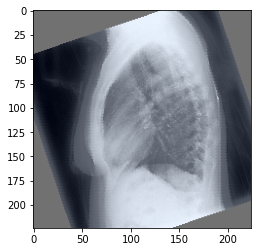

tensor([0.])


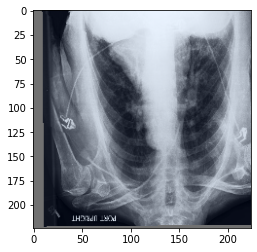

tensor([0.])


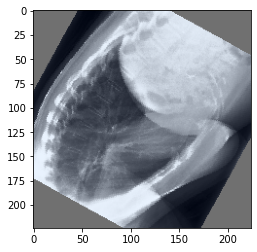

tensor([0.])


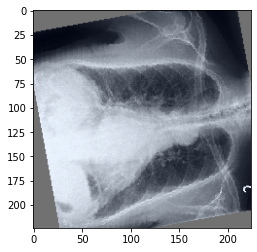

tensor([0.])


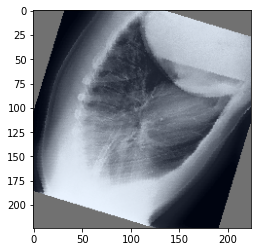

tensor([0.])


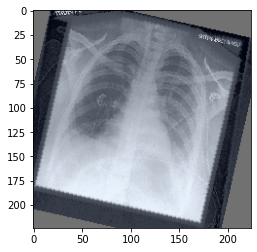

tensor([0.])


In [13]:
for batch in ColorCheXpertDataLoader.train:
    images, labels = batch
    for image, label in zip(images, labels):
        plot_image(image)
        print(label)
        break